<a href="https://colab.research.google.com/github/Elygledson/hate-speech-detector-using-bert/blob/main/hate_speech_detector_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
from transformers import TFAutoModel, AutoTokenizer


model = TFAutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input = tokenizer(['Ola, mundo!', 'oi, como estas gostaria de sair'], padding=True, truncation=True)
input

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 17553, 117, 1147, 106, 102, 0, 0, 0, 0], [101, 146, 22283, 117, 271, 3769, 21454, 125, 5197, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
import pandas as pd

df = pd.read_csv('2019-05-28_portuguese_hate_speech_binary_classification.csv')

In [ ]:
df = df[["text", "hatespeech_comb"]]

df.columns = ["text", "label"]

df.dropna(inplace=True)

df["label"] = df["label"].astype(int)

df.to_csv("processed_dataset.csv", index=False)

<ipython-input-8-43bb57b18351>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-8-43bb57b18351>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["label"].astype(int)


In [ ]:
df['label'].value_counts()

,count
label,
0,3882
1,1788


<Axes: xlabel='label'>

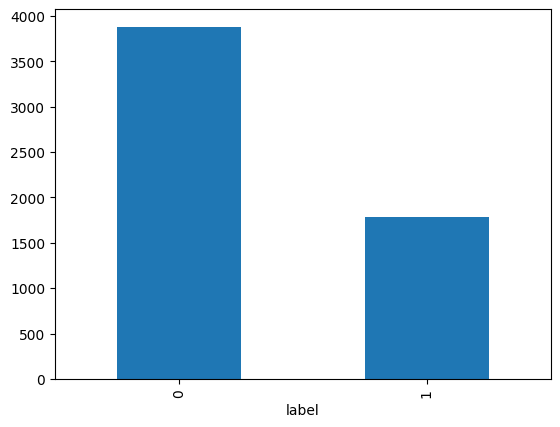

In [ ]:
df['label'].value_counts().plot(kind='bar')

In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 4536 rows
Validation set: 567 rows
Test set: 567 rows


In [ ]:
# Salvar os dados em arquivos CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [ ]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': 'train.csv', 'validation': 'val.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [ ]:
model_name = 'neuralmind/bert-large-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")  # Rename label to labels
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/4536 [00:00<?, ? examples/s]

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
)

trainer.train()

Step,Training Loss
10,0.641400
20,0.641300
30,0.635800
40,0.614000
50,0.594400
60,0.655200
70,0.648100
80,0.618600
90,0.612600
100,0.602400


TrainOutput(global_step=1701, training_loss=0.41242733140690124, metrics={'train_runtime': 1273.3862, 'train_samples_per_second': 10.686, 'train_steps_per_second': 1.336, 'total_flos': 3170430498041856.0, 'train_loss': 0.41242733140690124, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()

In [ ]:
results

{'eval_loss': 0.7994831204414368,
 'eval_runtime': 12.0541,
 'eval_samples_per_second': 47.038,
 'eval_steps_per_second': 2.987,
 'epoch': 3.0}

In [ ]:
texts = [
    "O curso é excelente! Porém, seria bom se o professor falasse mais alto,  pois quase não deu para ouvir. seu merda",
]

inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

inputs = inputs.to(device)
outputs = model(**inputs)

predictions = outputs.logits.argmax(axis=-1)

labels = ["Não é hate speech", "É hate speech"]
predicted_classes = [labels[p] for p in predictions]

for text, label in zip(texts, predicted_classes):
    print(f"Texto: {text}\nPrevisão: {label}\n")

Texto: O curso é excelente! Porém, seria bom se o professor falasse mais alto,  pois quase não deu para ouvir. seu merda
Previsão: É hate speech

